import modules

In [39]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from shapely.geometry import Point
import requests
from zipfile import ZipFile
import os
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
import seaborn as sns

Get Weather Stations details available from Met Eireann :'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
And read into dataframe : wsdf, there are 2083 stations

In [5]:
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head

<bound method NDFrame.head of        county  station name                            name  height(m)  \
0      Antrim          5880                 LH_RATHLIN_WEST         10   
1      Carlow          4415             TULLOW (Waterworks)         76   
2      Carlow          2414                     BORRIS G.S.         85   
3      Carlow          1214          CARLOW (SUGAR FACTORY)         58   
4      Carlow           115             HACKETSTOWN RECTORY        182   
...       ...           ...                             ...        ...   
2078  Wicklow          9820                   M.LOUGH OULER        457   
2079  Wicklow          2415           GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420             OLDBRIDGE (Oakview)        335   
2081  Wicklow          9915  M.GLEN IMAAL(BALLINABARNY FOR)        421   
2082  Wicklow          2424      ENNISKERRY (BALLYMAN HSE.)        107   

      easting  northing  latitude  longitude open year close year  
0      309200

The Values in 'open year' and 'close year' which describe the time range of recording for each staion are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '3000' and convert to int.
This allows us to filter the data based on Year and reduces the number of stations to 429

In [8]:
wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']].astype(int)
#Filter Weather Stations to those reporting data from 2014 to the present
wsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2015)]
wsdf.shape

(429, 10)

Get a visual idea of the distribution of the stations by superimposing a plot of the stations on a map of Ireland(state) using this shape file from here https://www.geoboundaries.org/data/1_3_3/zip/shapefile/IRL/IRL_ADM1.shp.zip

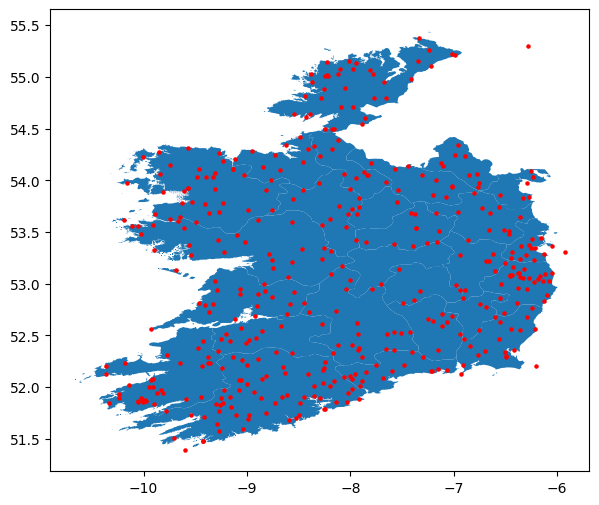

In [9]:
def stationinirelandplot(df):
    IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(wsdf, geometry=geometry) 
    gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);
stationinirelandplot(wsdf)

Remove Rathlin Island Station from dataframe as it is not in the state

In [11]:
wsdf = wsdf.loc[wsdf["name"] != 'LH_RATHLIN_WEST']
wsdf.shape

(428, 11)

For each of the stations, check if hourly data exists, if not drop it from the stations dataset, otherwise download the files to the zipped folder and unzip to the unzipped folder.
The files are named using the station name which is a number. For example the station name of ROCHES POINT is 1075 and the file to download is hly1075.zip. There are 25 staions remaining after this

In [ ]:
def validurl(url):
	try:
		get = requests.get(url)		 
		if get.status_code == 200:
			return True
		else:
			return False
	except requests.exceptions.RequestException as e:
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basezipfile='./weatherstationdata/zipped/hly'
baseunzipfile=basezipfile.replace("zipped", "unzipped")
for station in wsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationzipfile=basezipfile+str(station)+'.zip'
    stationzipfolder=stationzipfile[:-4]
    stationunzipfolder=stationzipfolder.replace("zipped", "unzipped")
    if validurl(stationurl):
        response = requests.get(stationurl)
        open(stationzipfile, "wb").write(response.content)
        with ZipFile(stationzipfile, 'r') as zip_ref:
                zip_ref.extractall(stationunzipfolder)
    else:
        wsdf = wsdf.loc[wsdf["station name"] != station]
stationinirelandplot(wsdf)

Get a distribution for the remaining stations. By finding the station's nearest neighbour and the distance between them using Balltree and Haversine method.
Distribution looks reasonably Ok, the distances are not significant

In [99]:
# convert the degrees to radians and store in the dataframe
wsdf[["latradian", "longradian"]] = np.deg2rad(wsdf[["latitude", "longitude"]])
ball_tree = BallTree(wsdf[["latradian", "longradian"]], metric="haversine")
distances,neighbours = ball_tree.query(
    wsdf[["latradian", "longradian"]],
    k=2,
    return_distance=True,
    sort_results=True,
)
#remove the nearwst neighbour and distance which is itself and 0
neighbours = neighbours[:, 1:]
distances = distances[:, 1:]

wsdf["nearest_stations_names"] = [
    wsdf["name"].iloc[n].to_list() for n in neighbours
]
wsdf["nearest_stations_station_names"] = [
    wsdf["station name"].iloc[n].to_list() for n in neighbours
]
wsdf["nearest_station_distance(rad)"] = distances
#convert distances to km
wsdf["nearest_station_distance(km)"] = distances*6371
wsdf['nearest_station_name'] = wsdf["nearest_stations_names"].str[0]
wsdf['nearest_station_station_name'] = wsdf["nearest_stations_station_names"].str[0].astype(int)
wsdf.drop(['nearest_stations_names', 'nearest_stations_station_names'], axis=1)
wsdf.to_csv('./weatherstationdata/stationinfo.csv')
#plot the distribution - Make this fancier
wsdf["nearest_station_distance(km)"].plot(kind='kde')

<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
624      Dublin           532        DUBLIN AIRPORT         71   316900   
741      Galway           275             MACE HEAD         21    7340

For each file in ./weatherstationdata/unzipped with the pattern hly*.csv - Use regex here
Find  'date:' and for each line until blank line create a dictionary for renaming the columns later
Find column headers starting with date, and check if there is a header called wdsp whic is Wind Speed, 
If there is then write the rest of the file into the processed folder
Rename the columns as per the dictionary
Delete unused columns
23 stations remain that have Windspeed data

In [21]:
wsdf.head

<bound method NDFrame.head of          county  station name                  name  height(m)  easting  \
15       Carlow           375              OAK PARK         62   273000   
43        Cavan           675            BALLYHAISE         78   245200   
136       Clare           518       SHANNON AIRPORT         15   137900   
224        Cork           775         SherkinIsland         21   100781   
245        Cork          3904          CORK AIRPORT        155   166500   
353        Cork          1075          ROCHES POINT         40   182779   
367        Cork           575            MOORE PARK         46   181900   
478     Donegal          1575            MALIN HEAD         20   241939   
536     Donegal          2075                FINNER         33   184300   
600      Dublin          3723              CASEMENT         91   304100   
624      Dublin           532        DUBLIN AIRPORT         71   316900   
741      Galway           275             MACE HEAD         21    7340

In [18]:
import os
wdict={}
stationunziphomefolder = basezipfile[:-4].replace('zipped','unzipped')
for folder in os.listdir(stationunziphomefolder):
    weatherdatafile=stationunziphomefolder+'/'+folder+"/"+folder+'.csv'
    inblock=False
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
            if 'date:' in line or (inblock and line.strip()):
                inblock=True
                wdict[line.split(":")[0]] = line.split("-")[1].strip()
            else:
                if inblock:
                    break
    with open(weatherdatafile, 'r') as wf:
        for lineno, line in enumerate(wf):
                if 'date,' in line:
                    firstline = lineno
                    break 
    if (',wdsp' in line): 
        with open(weatherdatafile, 'r') as wf:
            for lineno, line in enumerate(wf):    
                lines=wf.readlines()   
        # Write file
        stationprochomefolder=stationunziphomefolder.replace('unzipped','processed')
        weatherdataprocfile=stationprochomefolder+"/"+weatherdatafile.split("/")[-1]
        with open(weatherdataprocfile, 'w') as wwf:
            # iterate each line
            for lineno, line in enumerate(lines):
                if lineno > (firstline-2):
                    wwf.write(line)
    else:
        print("Not Processing : "+folder)
        stationname=int(folder[3:])
        wsdf = wsdf.loc[wsdf["station name"] != stationname]
wsdf.shape

Not Processing : hly1275
Not Processing : hly175


(23, 16)

In [23]:
wsdf.to_csv('./weatherstationdata/stationinfo_filtered.csv')

Check for missing values of in the dataset, using 
The data for 2013 is only partial, so that should be removed. 
## This step is out of order ##

In [ ]:
for k, v in wddf[wddf['wddir'] == ' '].groupby((wddf['wddir'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v.count())
    print('\n')

Read in the processed Weather Data file.
Combine the Weather Data into allwddf dataframe
For each file read into a dataframe 
Add the station name as a column

In [166]:
allwddf=pd. DataFrame()
for file in os.listdir(stationprochomefolder):
    weatherdataprocfile=stationprochomefolder+"/"+file
    wddf = pd.read_csv(weatherdataprocfile)
    wddf['station name'] = int(file[3:][:-4])
    allwddf=pd.concat([allwddf, wddf], axis=0,ignore_index=True)
    #break
allwddf.head


C:\Users\czl\AppData\Local\Temp\ipykernel_32984\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\3810692618.py:4: DtypeWarning: Columns (2,4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\3810692618.py:4: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  wddf = pd.read_csv(weatherdataprocfile)
C:\Users\czl\AppData\Local\Temp\ipykernel_32984\3810692618.py:4: DtypeWarning: Columns (2,6,7,8,9,12,14,15,16,

MemoryError: Unable to allocate 54.9 MiB for an array with shape (1, 7195186) and data type object

Clean the data 
As we are only interested in the datetime,Windspeed and station name, so remove all other columns
We are only interested in records from 2013 to 2022 inclusive, so remove any outside that range


In [139]:
columns = list(allwddf.columns.values)
retaincolumns=["date","wdsp","station name"]
allwddf = allwddf.loc[:, retaincolumns]
allwddf.head

<bound method NDFrame.head of                       date wdsp  station name
0        01-dec-1955 01:00   16          1075
1        01-dec-1955 02:00   11          1075
2        01-dec-1955 03:00    9          1075
3        01-dec-1955 04:00    5          1075
4        01-dec-1955 05:00   12          1075
...                    ...  ...           ...
8131541  31-jan-2023 20:00    7           875
8131542  31-jan-2023 21:00    8           875
8131543  31-jan-2023 22:00    7           875
8131544  31-jan-2023 23:00    7           875
8131545  01-feb-2023 00:00    5           875

[8131546 rows x 3 columns]>

We are only interested in records from 2013 to 2022 inclusive, so remove any outside that range
Convert date to datetime and use the range to remove the records
This reduces the number of records from 8131546 to 2015904

In [140]:
startdate=pd.to_datetime('2013-01-01', format='%Y-%m-%d')
enddate=pd.to_datetime('2023-01-01', format='%Y-%m-%d')
allwddf['Datetime'] = pd.to_datetime(allwddf['date'], format='%d-%b-%Y %H:%M')
mask = (allwddf['Datetime']  >= startdate) & (allwddf['Datetime'] < enddate)
allwddf = allwddf.loc[mask]
print(allwddf.shape)
allwddf.drop_duplicates(subset=['Datetime', 'station name'],inplace = True)
print(allwddf.shape)

(2015904, 4)
(2015904, 4)


C:\Users\czl\AppData\Local\Temp\ipykernel_32984\205224277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allwddf.drop_duplicates(subset=['Datetime', 'station name'],inplace = True)


Try to convert allwddf.wdsp to int
Get ValueError: invalid literal for int() with base 10: ' '


In [141]:
allwddf.wdsp=allwddf.wdsp.astype(int)


ValueError: invalid literal for int() with base 10: ' '

Look at unique values
As per the error message there are 1 or more values = ' '

In [142]:
print(set(allwddf.wdsp))

{0, '23', 2, 3, 4, 5, '20', 7, 6, 9, 10, 11, 12, '34', '6', 13, 14, 15, 16, 18, 19, 21, 20, 22, 23, 25, 26, 24, 27, 28, 29, 31, 30, 33, 34, 35, 36, 37, 38, 32, 39, 8, '22', 43, 40, 42, 41, 44, 47, 49, 45, 51, 46, 48, 50, 55, 56, 54, 52, '21', '32', '13', '51', '41', 17, '44', '30', '35', '56', '54', '2', '0', '3', '33', '39', '25', '43', 1, '29', '46', '37', '4', '24', '48', '36', '53', '49', '28', '10', '7', '47', '9', '17', '45', ' ', '19', '50', '16', '38', '11', '18', '42', '8', '31', '27', '40', '12', '52', '59', '1', '15', '26', '14', '55', '5'}


Check for missing or invalid values in wdsp column by using groupby with cumsum function

In [143]:
print(allwddf['wdsp'].value_counts()[' '])
for k, v in allwddf[allwddf['wdsp'] == ' '].groupby((allwddf['wdsp'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v['station name'])
    print(v.count())
    print('\n')

444
[group 20309]
2015-04-27 05:00:00
2015-04-27 07:00:00
501411    1075
501412    1075
501413    1075
Name: station name, dtype: int64
date            3
wdsp            3
station name    3
Datetime        3
dtype: int64


[group 20358]
2015-04-29 09:00:00
2015-04-29 15:00:00
501463    1075
501464    1075
501465    1075
501466    1075
501467    1075
501468    1075
501469    1075
Name: station name, dtype: int64
date            7
wdsp            7
station name    7
Datetime        7
dtype: int64


[group 20359]
2015-04-29 17:00:00
2015-04-29 21:00:00
501471    1075
501472    1075
501473    1075
501474    1075
501475    1075
Name: station name, dtype: int64
date            5
wdsp            5
station name    5
Datetime        5
dtype: int64


[group 172409]
2022-09-03 08:00:00
2022-09-06 11:00:00
724422    1175
724423    1175
724424    1175
724425    1175
724426    1175
          ... 
724493    1175
724494    1175
724495    1175
724496    1175
724497    1175
Name: station name, Length: 7

There are 444 records with blank data, By looking at the groups of occurences, they range from 1 or 2 hourly up to 3 whole days of recordings
A reasonable strategy to maintain the data consistency is to copy the windspeed measurement from the nearest neighbour we found earlier

In [165]:
allwddf.head

<bound method NDFrame.head of                      wdsp  station name
Datetime                               
2013-01-01 00:00:00     7          3904
2013-01-01 01:00:00     7          3904
2013-01-01 02:00:00     9          3904
2013-01-01 03:00:00     9          3904
2013-01-01 04:00:00     7          3904
...                   ...           ...
2022-12-31 19:00:00     3          1975
2022-12-31 20:00:00     3          1975
2022-12-31 21:00:00     3          1975
2022-12-31 22:00:00     1          1975
2022-12-31 23:00:00     1          1975

[2015904 rows x 2 columns]>

In [145]:

allwddf=allwddf
print(allwddf.shape)
allwddf=pd.merge(allwddf, wsdf[['station name','nearest_station_station_name']], on="station name", how="left")
print(allwddf.shape)
allwddf=pd.merge(allwddf, allwddf, left_on=["station name","Datetime"],right_on=['nearest_station_station_name',"Datetime"],how="right",suffixes=('', '_y'))
print(allwddf.shape)
mask = allwddf["wdsp"]  == ' '
allwddf.loc[mask, "wdsp"] = allwddf.loc[mask, "wdsp_y"]
print(allwddf.shape)
allwddf.head


(2015904, 4)
(2015904, 5)
(2015904, 9)
(2015904, 9)


<bound method NDFrame.head of                       date wdsp  station name            Datetime  \
0        01-jan-2013 00:00    7          3904 2013-01-01 00:00:00   
1        01-jan-2013 01:00    7          3904 2013-01-01 01:00:00   
2        01-jan-2013 02:00    9          3904 2013-01-01 02:00:00   
3        01-jan-2013 03:00    9          3904 2013-01-01 03:00:00   
4        01-jan-2013 04:00    7          3904 2013-01-01 04:00:00   
...                    ...  ...           ...                 ...   
2015899  31-dec-2022 19:00    3          1975 2022-12-31 19:00:00   
2015900  31-dec-2022 20:00    3          1975 2022-12-31 20:00:00   
2015901  31-dec-2022 21:00    3          1975 2022-12-31 21:00:00   
2015902  31-dec-2022 22:00    1          1975 2022-12-31 22:00:00   
2015903  31-dec-2022 23:00    1          1975 2022-12-31 23:00:00   

         nearest_station_station_name             date_y wdsp_y  \
0                                1075  01-jan-2013 00:00     11   
1      

Check for the Bad Values again

In [147]:

for k, v in allwddf[allwddf['wdsp'] == ' '].groupby((allwddf['wdsp'] != ' ').cumsum()):
    print(f'[group {k}]')
    print(v['Datetime'].min())
    print(v['Datetime'].max())
    print(v['station name'])
    print(v.count())
    print('\n')

All Good, drop the additional columns and set wdsp to int

In [159]:
allwddf.drop(allwddf.filter(regex='_y$').columns, axis=1, inplace=True)
allwddf.drop(columns=['nearest_station_station_name','date'], axis=1, inplace=True)
#allwddf.drop(columns=['date'], axis=1, inplace=True)
print(allwddf.shape)
allwddf.wdsp=allwddf.wdsp.astype(int)
allwddf.head

(2015904, 3)


<bound method NDFrame.head of                      wdsp  station name            Datetime
Datetime                                                   
2013-01-01 00:00:00     7          3904 2013-01-01 00:00:00
2013-01-01 01:00:00     7          3904 2013-01-01 01:00:00
2013-01-01 02:00:00     9          3904 2013-01-01 02:00:00
2013-01-01 03:00:00     9          3904 2013-01-01 03:00:00
2013-01-01 04:00:00     7          3904 2013-01-01 04:00:00
...                   ...           ...                 ...
2022-12-31 19:00:00     3          1975 2022-12-31 19:00:00
2022-12-31 20:00:00     3          1975 2022-12-31 20:00:00
2022-12-31 21:00:00     3          1975 2022-12-31 21:00:00
2022-12-31 22:00:00     1          1975 2022-12-31 22:00:00
2022-12-31 23:00:00     1          1975 2022-12-31 23:00:00

[2015904 rows x 3 columns]>

Remove the index and make Datetime the DatetimeIndex
Transpose allwddf to a pivoted dataset : pivwddf, such that every station is a column with the windspeed at that datetime as the value.
Write allwddf and pivwddf to csv file 

In [155]:
allwddf.head

<bound method NDFrame.head of                                   date  wdsp  station name            Datetime
Datetime                                                                      
2013-01-01 00:00:00  01-jan-2013 00:00     7          3904 2013-01-01 00:00:00
2013-01-01 01:00:00  01-jan-2013 01:00     7          3904 2013-01-01 01:00:00
2013-01-01 02:00:00  01-jan-2013 02:00     9          3904 2013-01-01 02:00:00
2013-01-01 03:00:00  01-jan-2013 03:00     9          3904 2013-01-01 03:00:00
2013-01-01 04:00:00  01-jan-2013 04:00     7          3904 2013-01-01 04:00:00
...                                ...   ...           ...                 ...
2022-12-31 19:00:00  31-dec-2022 19:00     3          1975 2022-12-31 19:00:00
2022-12-31 20:00:00  31-dec-2022 20:00     3          1975 2022-12-31 20:00:00
2022-12-31 21:00:00  31-dec-2022 21:00     3          1975 2022-12-31 21:00:00
2022-12-31 22:00:00  31-dec-2022 22:00     1          1975 2022-12-31 22:00:00
2022-12-31 23:00:00  3

In [164]:
allwddf.reset_index(drop=True)
allwddf = allwddf.set_index(pd.DatetimeIndex(allwddf['Datetime']))
allwddf.drop(columns=['Datetime'], axis=1, inplace=True)
allwddf.head
pivwddf=allwddf.pivot(index=allwddf.index, columns="station name", values="wdsp")
#allwddf.to_csv('./weatherstationdata/wsdata_clean.csv')
#pivwddf.to_csv('./weatherstationdata/wspivot.csv')
#Make this look good
#pivwddf["2022-01-20":"2022-01-21"].plot()

KeyError: 'Datetime'

Do a plot here
Split the data into monthly and quarterly segments on mean



In [62]:
pltpivwddf=pivwddf
#inputparams=allwddf.columns.values.tolist()
allwddf['Year']=allwddf.index.year
allwddf['Month']=allwddf.index.month
allwddf['Quarter']=allwddf.index.quarter
allwddf['YM']=allwddf['Year']*100+allwddf['Month']
allwddf['YM']=allwddf['YM'].astype(str)
allwddf['QY']=allwddf['Year']*10+allwddf['Quarter']
allwddf['QY']=allwddf['QY'].astype(str)
#pltpivwddf['Week']=pltpivwddf.index.week

mthallwddf=allwddf.groupby(['station name','YM','Year', 'Month']).mean()
mthallwddf=mthallwddf[['wdsp']].reset_index()

qtrallwddf=allwddf.groupby(['station name','QY','Year','Quarter']).max()
qtrallwddf=qtrallwddf[['wdsp']].reset_index()


#mthallwddf.head
qtrallwddf.head


C:\Users\czl\AppData\Local\Temp\ipykernel_32984\1119288895.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mthallwddf=allwddf.groupby(['station name','YM','Year', 'Month']).mean()


<bound method NDFrame.head of      station name     QY  Year  Quarter  wdsp
0             275  20141  2014        1    55
1             275  20142  2014        2    34
2             275  20143  2014        3    34
3             275  20144  2014        4    44
4             275  20151  2015        1    48
..            ...    ...   ...      ...   ...
823          4935  20214  2021        4    34
824          4935  20221  2022        1    38
825          4935  20222  2022        2    31
826          4935  20223  2022        3    25
827          4935  20224  2022        4    23

[828 rows x 5 columns]>

Plot Station mean Windspeeds by Quarter

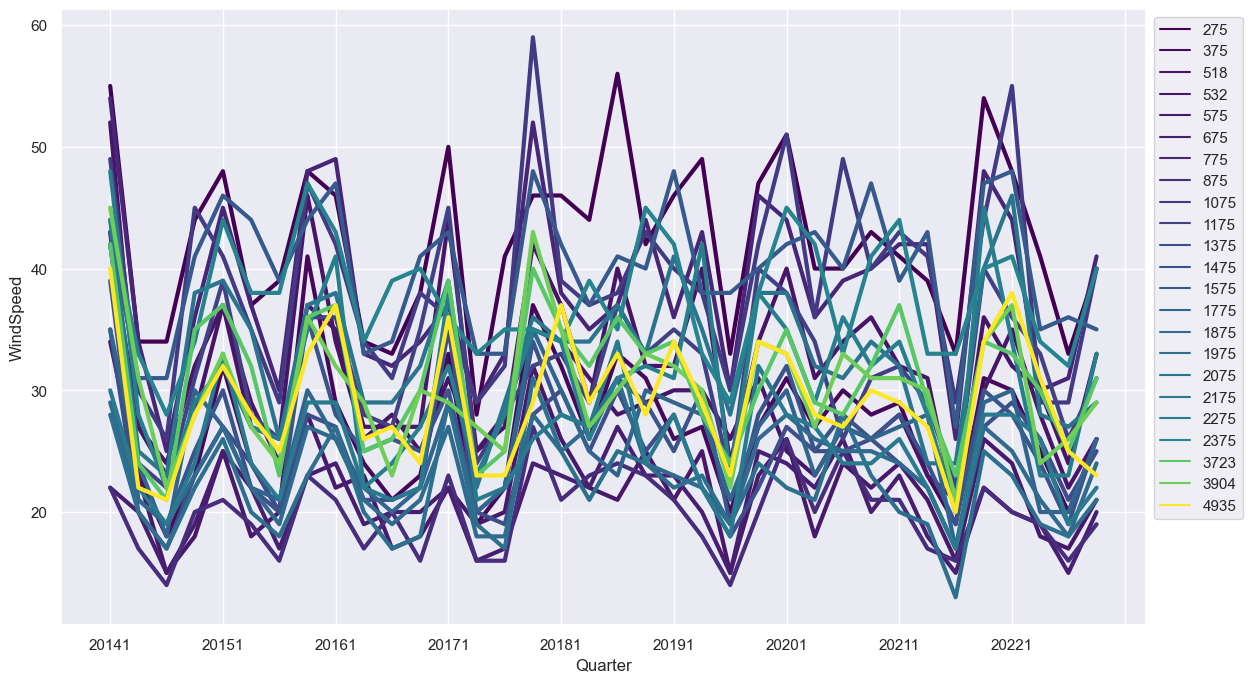

In [63]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=qtrallwddf, x ='QY', y = 'wdsp',
                  hue='station name', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('WindSpeed')
plt.xlabel('Quarter')
plt.show()

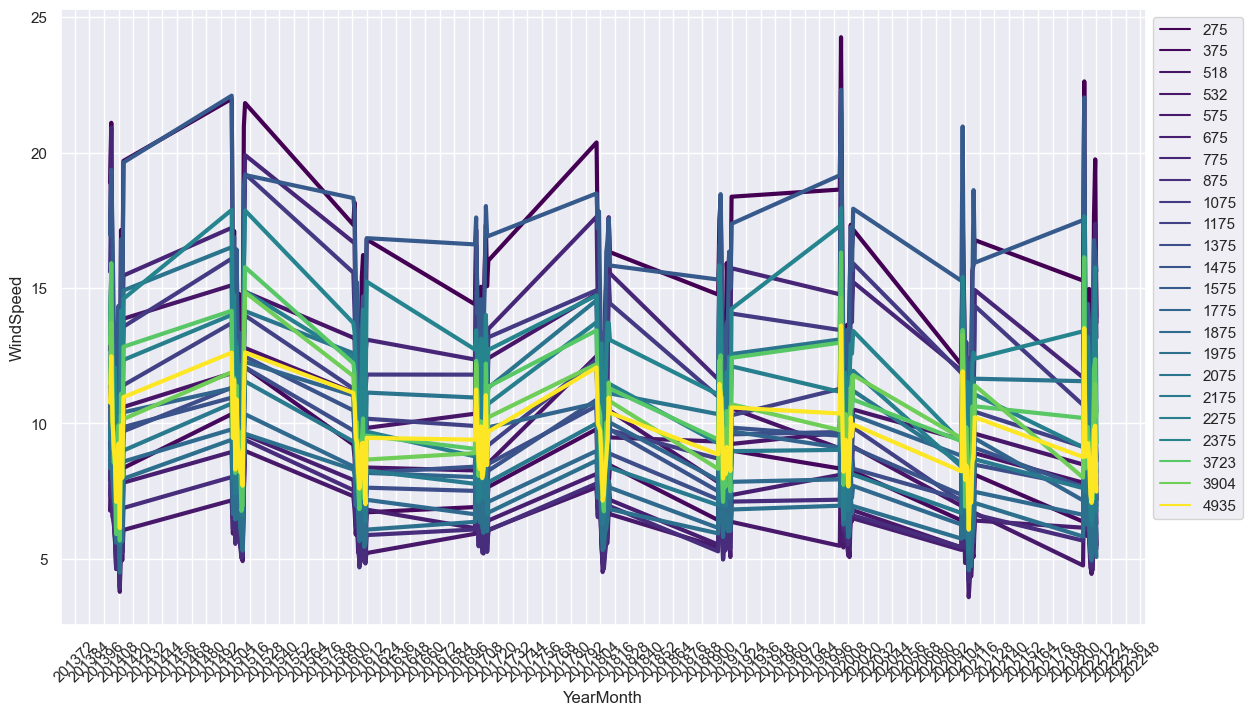

In [67]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=mthallwddf, x ='YM', y = 'wdsp',
                  hue='station name', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
ax.tick_params(axis='x', rotation=45)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('WindSpeed')
plt.xlabel('YearMonth')
plt.show()

##  No Need to rerun - Download Job  ##
Download WindGeneration data for Ireland(state)
Get the Actual Wind Generation data from https://www.smartgriddashboard.com/DashboardService.svc
Last 3o days data available by using this url.
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=04-Feb-2023%2000:00&dateto=05-Mar-2023%2023:59

Crafting urls by manipulating the url parameters allows the possibility of downloading data for custom timeframes.
Attempting to download a full year resulted in an empty file
It was possible to download data in monthly chunks like so
https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom=01-Dec-2022%2000:00&dateto=31-Dec-2022%2023:59
Use the calendar and datetime libraries to get the first and last days of each month from 2013 to 2022 and inject these into the url to download the data

In [ ]:
import calendar
from datetime import datetime

baseurl="https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ROI&datefrom="
separator="%2000:00&dateto="
end="%2023:59"
edfolder="./windgeneration/monthly/"
edfileprefix='WindGenerationROIMonthly'
edfileextension='.csv'

for year in range(2013,2023):
    for month in range(1, 13):
        input_dt = datetime(year, month, 1)
        datefrom=input_dt.strftime('%d-%b-%Y')
        res = calendar.monthrange(input_dt.year, input_dt.month)
        day = res[1]
        last_dt = datetime(year, month, day)
        dateto = last_dt.strftime('%d-%b-%Y')
        monthto=last_dt.strftime('%Y%m')
        url=baseurl+datefrom+separator+dateto+end
        edfile=edfolder+edfileprefix+monthto+edfileextension
        print(url)
        print(edfile)
        if validurl(url):
            response = requests.get(url)
            open(edfile, "wb").write(response.content)

Plot a sample of the data

In [ ]:
file="./windgeneration/monthly/WindGenerationROIMonthly202201.csv"
wgdf=pd.read_csv(file)

wgdf['datetime'] = pd.to_datetime(wgdf['DATE & TIME'], format='%d %B %Y %H:%M')
columns = list(wgdf.columns.values) 
wgdf.columns = wgdf.columns.str.strip()
wgdf.dtypes
plt.plot(wgdf['datetime'], wgdf['ACTUAL WIND(MW)'])

##  No Need to rerun - Processing Job  ##
Process the files and merge into Single Dataframe, write to file ./windgeneration/processed/WindGenerationROIAll.csv

In [ ]:
wgalldf=pd.DataFrame()
wgfolder="./windgeneration/monthly/"
wgfileprefix='WindGenerationROIMonthly'
wgfileextension='.csv'
wgprocessedfolder="./windgeneration/processed/"
wgprocessedfile='WindGenerationROIAll.csv'
for file in os.listdir(wgfolder):
    wgfile=wgfolder+file
    #print(wgfile)
    wgdf=pd.read_csv(wgfile)
    wgalldf=pd.concat([wgalldf, wgdf], axis=0,ignore_index=True)

columns = list(wgalldf.columns.values) 
wgalldf.columns = wgalldf.columns.str.strip()
wgalldf.drop_duplicates(subset=['DATE & TIME', 'ACTUAL WIND(MW)'],inplace = True)
wgalldf['Datetime'] = pd.to_datetime(wgalldf['DATE & TIME'], format='%d %B %Y %H:%M')

wgalldf.reset_index(drop=True) #
wgalldf['Datetime'] = pd.to_datetime(wgalldf['Datetime'])
wgalldf = wgalldf.drop(columns=['DATE & TIME', 'FORECAST WIND(MW)','REGION'])
cols = wgalldf.columns.tolist()
cols = cols[-1:] + cols[:-1]
wgalldf = wgalldf[cols]
wgalldf = wgalldf.set_index(pd.DatetimeIndex(wgalldf['Datetime']))
#Replace invalid values with '0'
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].replace('-','0')
#Convert 'ACTUAL WIND(MW)' to int
wgalldf['ACTUAL WIND(MW)'] = wgalldf['ACTUAL WIND(MW)'].astype('int')
#Replace negative values with positive counterparts, seems to be a data entry error after visual inspection
wgalldf['ACTUAL WIND(MW)'] = np.where(wgalldf['ACTUAL WIND(MW)'] < 0,
                                      wgalldf['ACTUAL WIND(MW)'] * -1,
                                      wgalldf['ACTUAL WIND(MW)'])
#Reduce Sample Size from Quarter Hourly to hourly, use the mean for the hour as the new value
wgalldf = wgalldf.resample("H").max()

wgalldf.to_csv('./windgeneration/windgen2014-2022.csv')
wgalldf.head
#[78888 rows x 2 columns]>
#wgalldf.dtypes

Merge the Wind Speed and Windgeneration data

In [ ]:
windall = pivwddf.join(wgalldf, how='outer')
windall.drop('Datetime', axis=1, inplace=True)
windall.dtypes